# Verification Notebook Walkthrough

> **Goal**
> This notebook evaluates the **two‑stage wildlife camera‑trap model** I developed for my M.Sc. project:
>
> 1. **Stage 1 – Object Detection:** [MegaDetector v6](https://github.com/microsoft/CameraTraps/blob/main/megadetector.md) (ONNX) locates *animals* and *vehicles*.
> 2. **Stage 2 – Species Classification:** A fine‑tuned **ConvNeXt‑Tiny** classifier refines the animal detections into 13 species.
>
> We assess performance on two held‑out verification splits:
>
> | Split               | Scenario                       | Purpose                        |
> | ------------------- | ------------------------------ | ------------------------------ |
> | `verify_cis_test`   | Same cameras/sites as training | Checks over‑fitting            |
> | `verify_trans_test` | New, unseen cameras/sites      | Measures domain generalisation |

---

## 0. Notebook Preliminaries

```python
import os, json, cv2, onnxruntime as ort, pandas as pd, numpy as np
from pathlib import Path
```

* **Paths** for data (`data/verification`), cleaned COCO‑style annotations, and `models/` are declared up‑front so the rest of the code is portable.
* Both ONNX models are loaded once with GPU fall‑back using `CUDAExecutionProvider` → `CPUExecutionProvider`.

---

## 1. Stage 1 – Running MegaDetector

```python
run_megadetector_on_split(split, session, filenames, conf_th=0.35)
```

1. For every JPEG in the split, the image is resized to **640×640** for inference.
2. Raw detections (`x1 y1 x2 y2 conf class_id`) are rescaled back to original resolution.
3. Results are written to **`reports/<split>_md_preds.csv`**.

*We keep a low confidence cut‑off (0.35) here so borderline boxes can still be recovered by the classifier in stage 2.*

---

## 2. Stage 2 – Cropping & Classifying Animals

Key constants

| Parameter               | Value    | Rationale                              |
| ----------------------- | -------- | -------------------------------------- |
| `CONF_THRESH`           | **0.55** | Filters weak species scores            |
| `IMG_SIZE`              | 224      | ConvNeXt‑Tiny input                    |

Processing loop:

1. **Vehicle boxes** are passed straight through and labelled `car` (COCO id 33).
2. **Animal boxes** are cropped, centre‑padded → 224x224, normalised (ImageNet stats), and classified.
3. Softmax probabilities are computed; only predictions ≥ 0.55 are retained.
4. Final per‑image detections are saved to **`reports/<split>_final_predictions.json`**.

The helper `debug_confidence_scores()` prints before‑/after‑threshold stats so it’s easy to spot if the cut‑off is too harsh.

---

## 3. Quantitative Evaluation

We compare predictions with ground‑truth COCO annotations using two spatial criteria:

* **IoU ≥ 0.30**
* **≥ 60 % GT box enclosed** by the prediction – useful for truncated animals or zoomed crops.

Metrics per split are exported under **`reports/eval_reports/`**:

| File                            | Content                                                 |
| ------------------------------- | ------------------------------------------------------- |
| `*_classification_report.csv`   | Precision/Recall/F1 for every class                     |
| `*_confusion_matrix.csv / .png` | Raw counts + normalised heat‑map                        |
| `*_comprehensive_metrics.csv`   | One‑row summary incl. weighted F1, per‑class accuracies |
| `*_unmatched_preds.csv`         | Boxes with no matching ground truth                     |

### Domain‑shift analysis

The cell *“Domain Shift: Per‑Class Accuracy Drop”* merges the two `*_comprehensive_metrics.csv` files and plots **cis – trans** accuracy deltas so degradation is visible at a glance.

---

## 4. Qualitative Inspection

Running the final cell lets the reader *visually* verify the model:

```python
GT  → green boxes
PR  → blue boxes
```

*Five random images per split* are displayed side‑by‑side (GT vs Prediction) so mis‑labelled species or missed detections are immediately obvious.

---

## 5. Ready-to-Run Setup

All heavy computations—MegaDetector inference, classification, and metric generation—have already been cached to `reports/`. Simply **run the notebook top-to-bottom** to reproduce every figure and table; no additional configuration is required.

### Fixed Model Pipeline

| Stage | Model | Confidence Threshold | Purpose |
|-------|-------|----------------------|---------|
| **Detection** | MegaDetector v6 (ONNX) | **0.35** | Favors recall so borderline boxes reach the classifier |
| **Classification** | ConvNeXt-Tiny (ONNX) | **0.55** | Rejects low-probability crops as background |

These thresholds were selected via grid-search on a validation subset and should remain unchanged for this verification study.

### Evaluation-Only Matching Rules

During metric calculation we match predictions to ground truth if **either** of the following holds:

* **IoU ≥ 0.30**, or  
* **≥ 60 % of the GT box is contained** within the predicted box.

These criteria affect *only* scoring — they do **not** feed back into the model.

### Re-evaluation

If you update annotations and need fresh metrics, simply rerun the *Evaluation* section; cached detections remain valid.

> **Tip:** Jump straight to the final qualitative-inspection cell to browse ground-truth vs prediction overlays without recalculating anything.



## 6. Project Directory Snapshot

```
.
├── data/
│   └── verification/                  # ~1.5 k evaluation images
├── models/
│   ├── megadetectorv6.onnx
│   └── convnext_classifier.onnx
├── reports/
│   ├── verify_*_md_preds.csv
│   ├── verify_*_final_predictions.json
│   └── eval_reports/
│       ├── *_classification_report.csv
│       ├── *_confusion_matrix.(csv|png)
│       ├── *_comprehensive_metrics.csv
│       └── *_unmatched_preds.csv
└── verification.ipynb                     # this walkthrough refers to
```

---

### Acknowledgements

* Megadetector v6 by Microsoft AI for Earth.
* ConvNeXt backbone pretrained on ImageNet‑22k (Krizhevsky et al.).

---



In [6]:
import onnxruntime as ort
from pathlib import Path
import json
import onnxruntime as ort
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm

# --- Paths ---
SPLITS = ["verify_cis_test", "verify_trans_test"]
IMG_DIR = Path("data/verification")
JSON_PATHS = {
    "verify_cis_test": Path("data/preprocessed/annotations/cleaned/verify_cis_test.json"),
    "verify_trans_test": Path("data/preprocessed/annotations/cleaned/verify_trans_test.json")
}

# ONNX models
MD_ONNX_PATH =  "models/megadetectorv6.onnx"
CLS_ONNX_PATH = "models/convnext_classifier.onnx"

# Output directory for detections and metrics
OUTPUT_DIR = Path("reports/")

# Load ONNX models
available = ort.get_available_providers()
providers = (["CUDAExecutionProvider", "CPUExecutionProvider"]
                    if "CUDAExecutionProvider" in available
                    else ["CPUExecutionProvider"])

md_sess = ort.InferenceSession(str(MD_ONNX_PATH), providers=providers)
cls_sess = ort.InferenceSession(str(CLS_ONNX_PATH), providers=providers)

print("Models loaded successfully.")

# Category mapping
CATEGORY_NAME_TO_ID = {
    "bobcat": 6,
    "opossum": 1,
    "coyote": 9,
    "raccoon": 3,
    "bird": 11,
    "dog": 8,
    "cat": 16,
    "squirrel": 5,
    "rabbit": 10,
    "skunk": 7,
    "rodent": 99,
    "badger": 21,
    "deer": 34,
    "car": 33  # for detector only
}
CATEGORY_ID_TO_NAME = {v: k for k, v in CATEGORY_NAME_TO_ID.items()}

# Classifier class list (excluding car)
CLASSIFIER_CLASSES = [
    "badger", "bird", "bobcat", "cat", "coyote", "deer", "dog", "opossum",
    "rabbit", "raccoon", "rodent", "skunk", "squirrel"
]


Models loaded successfully.


In [7]:
def load_megadetector_session(model_path):
    return ort.InferenceSession(model_path)

def preprocess_image(img, input_size=(640, 640)):
    img_resized = cv2.resize(img, input_size)
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    img_norm = img_rgb.astype(np.float32) / 255.0
    img_transposed = np.transpose(img_norm, (2, 0, 1))  # HWC - CHW
    return img_transposed[np.newaxis, :, :, :]  

def get_filenames_from_json(json_path):
    with open(json_path, "r") as f:
        data = json.load(f)
    return set(img["file_name"] for img in data["images"])

def run_megadetector_on_split(split, session, filenames, conf_th=0.35, out_dir=OUTPUT_DIR):
    img_dir = IMG_DIR
    csv_path = out_dir / f"{split}_md_preds.csv"
    records = []
    
    image_paths = [img_path for img_path in img_dir.glob("*.jpg") if img_path.name in filenames]
    for img_path in tqdm(image_paths, desc=f"Running MD on {split}"):
        

        img = cv2.imread(str(img_path))
        if img is None:
            print(f" Failed to read {img_path}")
            continue

        orig_h, orig_w = img.shape[:2]
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img_rgb, (640, 640))
        img_input = img_resized.astype(np.float32) / 255.0
        img_input = np.transpose(img_input, (2, 0, 1))[np.newaxis, :, :, :]

        outputs = session.run(None, {"images": img_input})
        raw = outputs[0][0]  # shape: (N, 6)

        scale_x = orig_w / 640
        scale_y = orig_h / 640

        for det in raw:
            x1, y1, x2, y2, conf, cls_id = det
            if conf < conf_th:
                continue

            cls_id = int(cls_id)
            if cls_id == 0:
                cls_name = "animal"
            elif cls_id == 1:
                cls_name = "vehicle"
            else:
                continue  # skip unknowns

            # Rescale to original size
            x1 *= scale_x
            y1 *= scale_y
            x2 *= scale_x
            y2 *= scale_y

            records.append({
                "filename": img_path.name,
                "x1": float(x1), "y1": float(y1), "x2": float(x2), "y2": float(y2),
                "conf": float(conf),
                "class": cls_name,
                "class_id": cls_id
            })

    pd.DataFrame(records).to_csv(csv_path, index=False)
    print(f" Saved predictions for {split} → {csv_path}")



In [8]:
session = load_megadetector_session(MD_ONNX_PATH)

for split in SPLITS:
    filenames = get_filenames_from_json(JSON_PATHS[split])
    run_megadetector_on_split(split, session, filenames)

Running MD on verify_cis_test: 100%|██████████| 629/629 [02:38<00:00,  3.98it/s]


 Saved predictions for verify_cis_test → reports\verify_cis_test_md_preds.csv


Running MD on verify_trans_test: 100%|██████████| 879/879 [03:39<00:00,  4.00it/s]

 Saved predictions for verify_trans_test → reports\verify_trans_test_md_preds.csv


In [9]:
def clip_box(x1, y1, x2, y2, img_w, img_h):
    x1 = max(0, min(int(x1), img_w - 1))
    y1 = max(0, min(int(y1), img_h - 1))
    x2 = max(0, min(int(x2), img_w - 1))
    y2 = max(0, min(int(y2), img_h - 1))
    return x1, y1, x2, y2

In [10]:
# Config
CONF_THRESH = 0.55
IMG_SIZE = 224
input_name = cls_sess.get_inputs()[0].name

def preprocess_crop(img):
   
    # Convert BGR to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Direct resize to 224x224
    resized = cv2.resize(img_rgb, (224, 224))
    
    # Normalize
    norm = resized.astype(np.float32) / 255.0
    mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
    std = np.array([0.229, 0.224, 0.225], dtype=np.float32)
    norm = (norm - mean) / std
    
    # Convert to CHW format and add batch dimension
    transposed = np.transpose(norm, (2, 0, 1))
    return transposed[np.newaxis, :, :, :]

def debug_confidence_scores(split, results_before_threshold, results_after_threshold):
    """
    Debug confidence score distributions
    """
    # Extract confidence scores before and after thresholding
    confs_before = [r["conf"] for r in results_before_threshold if r.get("conf")]
    confs_after = [r["conf"] for r in results_after_threshold if r.get("conf")]
    
    print(f"\n {split} - Confidence Analysis:")
    print(f"Total detections before threshold: {len(confs_before)}")
    print(f"Total detections after threshold (≥{CONF_THRESH}): {len(confs_after)}")
    print(f"Rejected: {len(confs_before) - len(confs_after)}")
    
    if confs_before:
        print(f"Confidence stats (before threshold):")
        print(f"  Mean: {np.mean(confs_before):.3f}")
        print(f"  Median: {np.median(confs_before):.3f}")
        print(f"  Min: {np.min(confs_before):.3f}")
        print(f"  Max: {np.max(confs_before):.3f}")
        print(f"  <0.3: {sum(c < 0.3 for c in confs_before)}")
        print(f"  0.3-0.5: {sum(0.3 <= c < 0.5 for c in confs_before)}")
        print(f"  0.5-0.55: {sum(0.5 <= c < 0.55 for c in confs_before)}")
        print(f"  ≥0.55: {sum(c >= 0.55 for c in confs_before)}")


def softmax(x):
    e_x = np.exp(x - np.max(x))  # numerical stability
    return e_x / e_x.sum()

# Process each split
for split in SPLITS:
    print(f"\nProcessing split: {split}")
    md_csv = OUTPUT_DIR / f"{split}_md_preds.csv"
    df = pd.read_csv(md_csv)
    
    filenames = get_filenames_from_json(JSON_PATHS[split])
    df = df[df["filename"].isin(filenames)]

    results_all = []  # Before thresholding
    results = []      # After thresholding
    img_dir = IMG_DIR
    grouped = df.groupby("filename")

    for filename, rows in tqdm(grouped, desc=f"Processing {split}"):
        img_path = img_dir / filename
        img = cv2.imread(str(img_path))
        if img is None:
            continue
        H, W = img.shape[:2]

        for _, row in rows.iterrows():
            x1, y1, x2, y2 = clip_box(row.x1, row.y1, row.x2, row.y2, W, H)

            if x2 <= x1 or y2 <= y1:
                continue

            if row["class"] == "vehicle":
                pred = {
                    "filename": filename,
                    "bbox": [int(x1), int(y1), int(x2), int(y2)],
                    "category": "car",
                    "category_id": 33,
                    "conf": float(row.conf)
                }
                results_all.append(pred)
                results.append(pred)  # No threshold for vehicles
                
            elif row["class"] == "animal":
                crop = img[y1:y2, x1:x2]
                if crop.size == 0:
                    continue

                inp = preprocess_crop(crop)  # Use the fixed preprocessing
                logits = cls_sess.run(None, {input_name: inp})[0][0]
                
                probs = softmax(logits.astype(np.float32))
                cls_idx = np.argmax(probs)
                conf = probs[cls_idx]
                
                name = CLASSIFIER_CLASSES[cls_idx]
                coco_id = CATEGORY_NAME_TO_ID[name]

                pred = {
                    "filename": filename,
                    "bbox": [int(x1), int(y1), int(x2), int(y2)],
                    "category": str(name),
                    "category_id": int(coco_id),
                    "conf": float(conf)
                }
                results_all.append(pred)
                
                # Only add to final results if above threshold
                if conf >= CONF_THRESH:
                    results.append(pred)
                
    debug_confidence_scores(split, results_all, results)

    # Save final predictions
    out_json = OUTPUT_DIR / f"{split}_final_predictions.json"
    with open(out_json, "w") as f:
        json.dump(results, f, indent=2)
    print(f"Saved {len(results)} predictions to {out_json}")


Processing split: verify_cis_test


Processing verify_cis_test: 100%|██████████| 610/610 [00:34<00:00, 17.93it/s]



 verify_cis_test - Confidence Analysis:
Total detections before threshold: 670
Total detections after threshold (≥0.55): 660
Rejected: 10
Confidence stats (before threshold):
  Mean: 0.888
  Median: 0.896
  Min: 0.229
  Max: 0.995
  <0.3: 2
  0.3-0.5: 5
  0.5-0.55: 3
  ≥0.55: 660
Saved 660 predictions to reports\verify_cis_test_final_predictions.json

Processing split: verify_trans_test


Processing verify_trans_test: 100%|██████████| 835/835 [00:39<00:00, 21.30it/s]


 verify_trans_test - Confidence Analysis:
Total detections before threshold: 911
Total detections after threshold (≥0.55): 884
Rejected: 27
Confidence stats (before threshold):
  Mean: 0.862
  Median: 0.878
  Min: 0.168
  Max: 0.995
  <0.3: 5
  0.3-0.5: 20
  0.5-0.55: 4
  ≥0.55: 882
Saved 884 predictions to reports\verify_trans_test_final_predictions.json


In [11]:
import json
import numpy as np
import pandas as pd
from pathlib import Path
from collections import defaultdict
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


GT_DIR = Path("../data/preprocessed/annotations/cleaned")
IOU_THRESHOLD = 0.3
OUTPUT_CSV_DIR = Path("reports/eval_reports")
OUTPUT_CSV_DIR.mkdir(parents=True, exist_ok=True)


def gt_in_pred(gt_box, pred_box, containment_thresh=0.9):
    """
    Returns True if the ground-truth box is at least 90% contained within the predicted box.
    """
    gx1, gy1, gx2, gy2 = gt_box
    px1, py1, px2, py2 = pred_box

    # Compute intersection rectangle
    ix1 = max(gx1, px1)
    iy1 = max(gy1, py1)
    ix2 = min(gx2, px2)
    iy2 = min(gy2, py2)

    inter_w = max(0, ix2 - ix1)
    inter_h = max(0, iy2 - iy1)
    inter_area = inter_w * inter_h

    gt_area = max(1, (gx2 - gx1) * (gy2 - gy1))

    return (inter_area / gt_area) >= containment_thresh

def iou(boxA, boxB):
    """
    Compute Intersection over Union (IoU) between two bounding boxes.
    Boxes are in [x1, y1, x2, y2] format.
    """
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interW = max(0, xB - xA)
    interH = max(0, yB - yA)
    interArea = interW * interH

    boxAArea = max(1, (boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxBArea = max(1, (boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou



for split in SPLITS:
    print(f"\nEvaluating split: {split}")
    
    pred_file = f"reports/{split}_final_predictions.json"
    gt_file = JSON_PATHS[split]

    preds = json.load(open(pred_file))
    gt_data = json.load(open(gt_file))

    image_id_to_name = {img["id"]: img["file_name"] for img in gt_data["images"]}
    gt_by_filename = defaultdict(list)
    for ann in gt_data["annotations"]:
        fn = image_id_to_name[ann["image_id"]]
        x, y, w, h = ann["bbox"]
        gt_box = [x, y, x + w, y + h]
        gt_by_filename[fn].append({"bbox": gt_box, "category_id": ann["category_id"]})
    id_to_name = {cat["id"]: cat["name"] for cat in gt_data["categories"]}

    y_true, y_pred, unmatched_preds = [], [], []
    
    for pred in preds:
        fn = pred["filename"]
        pred_box = pred["bbox"]
        pred_cat = pred["category_id"]

        best_gt = None
        for gt in gt_by_filename.get(fn, []):
            gt_box = gt["bbox"]
            iou_score = iou(pred_box, gt_box)
            containment = gt_in_pred(gt_box, pred_box, containment_thresh=0.6) 
            
            # Simple OR condition - accept if EITHER condition is met
            if iou_score >= IOU_THRESHOLD or containment:
                best_gt = gt
                break  # Take the first match that satisfies either condition

        if best_gt:
            y_true.append(best_gt["category_id"])
            y_pred.append(pred_cat)
        else:
            unmatched_preds.append(pred)

    print(f"  Total predictions: {len(preds)}")
    print(f"  Matched (IoU ≥ {IOU_THRESHOLD}): {len(y_true)}")
    print(f"  Unmatched: {len(unmatched_preds)}")

    # Calculate accuracy metrics
    y_true_names = [id_to_name.get(i, str(i)) for i in y_true]
    y_pred_names = [id_to_name.get(i, str(i)) for i in y_pred]
    
    # Overall accuracy
    overall_accuracy = accuracy_score(y_true_names, y_pred_names)
    print(f"  Overall Accuracy: {overall_accuracy:.3f}")

    # Classification report for detailed metrics
    report_dict = classification_report(
        y_true_names,
        y_pred_names,
        output_dict=True,
        zero_division=0
    )
    
    # Weighted accuracy
    weighted_accuracy = report_dict['weighted avg']['f1-score'] 
    print(f"  Weighted F1-Score: {weighted_accuracy:.3f}")

    # Per-class accuracy
    print("  Per-class Accuracy:")
    class_accuracies = {}
    for class_name in sorted(set(y_true_names)):
        # Get indices for this class in true labels
        class_indices = [i for i, true_label in enumerate(y_true_names) if true_label == class_name]
        if class_indices:
            class_true = [y_true_names[i] for i in class_indices]
            class_pred = [y_pred_names[i] for i in class_indices]
            class_acc = accuracy_score(class_true, class_pred)
            class_accuracies[class_name] = class_acc
            print(f"    {class_name}: {class_acc:.3f}")

    # Create comprehensive metrics summary
    metrics_summary = {
        "split": split,
        "total_predictions": len(preds),
        "matched_predictions": len(y_true),
        "unmatched_predictions": len(unmatched_preds),
        "matching_rate": len(y_true) / len(preds),
        "overall_accuracy": overall_accuracy,
        "weighted_f1": weighted_accuracy,
        **{f"{class_name}_accuracy": acc for class_name, acc in class_accuracies.items()}
    }
    
    # Save comprehensive metrics
    metrics_df = pd.DataFrame([metrics_summary])
    metrics_df.to_csv(OUTPUT_CSV_DIR / f"{split}_comprehensive_metrics.csv", index=False)

    # Original outputs
    report_df = pd.DataFrame(report_dict).transpose()
    report_df.to_csv(OUTPUT_CSV_DIR / f"{split}_classification_report.csv")

    cm = confusion_matrix(y_true_names, y_pred_names, labels=sorted(set(id_to_name.values())))
    cm_df = pd.DataFrame(cm, index=sorted(set(id_to_name.values())), columns=sorted(set(id_to_name.values())))
    cm_df.to_csv(OUTPUT_CSV_DIR / f"{split}_confusion_matrix.csv")

    labels_sorted = sorted(set(id_to_name.values()))

    # Normalize by true label (row-wise) - fix division by zero
    cm_normalized = cm.astype(np.float64)
    row_sums = cm_normalized.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1  # Avoid division by zero
    cm_normalized = cm_normalized / row_sums
    cm_normalized_df = pd.DataFrame(cm_normalized, index=labels_sorted, columns=labels_sorted)

    # Save normalized confusion matrix as PNG
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_normalized_df, annot=True, fmt=".2f", cmap="Blues", vmin=0, vmax=1,
                xticklabels=True, yticklabels=True)
    plt.title(f"{split} Normalized Confusion Matrix (Row-wise)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(OUTPUT_CSV_DIR / f"{split}_confusion_matrix.png", dpi=300)
    plt.close()

    pd.DataFrame(unmatched_preds).to_csv(OUTPUT_CSV_DIR / f"{split}_unmatched_preds.csv", index=False)

print("\nEvaluation complete!")


Evaluating split: verify_cis_test
  Total predictions: 660
  Matched (IoU ≥ 0.3): 636
  Unmatched: 24
  Overall Accuracy: 0.978
  Weighted F1-Score: 0.978
  Per-class Accuracy:
    bird: 1.000
    bobcat: 0.972
    car: 1.000
    cat: 0.961
    coyote: 0.934
    deer: 1.000
    dog: 1.000
    opossum: 0.980
    rabbit: 1.000
    raccoon: 1.000
    rodent: 1.000
    skunk: 0.889
    squirrel: 0.955

Evaluating split: verify_trans_test
  Total predictions: 884
  Matched (IoU ≥ 0.3): 846
  Unmatched: 38
  Overall Accuracy: 0.939
  Weighted F1-Score: 0.941
  Per-class Accuracy:
    bird: 1.000
    bobcat: 0.898
    car: 1.000
    cat: 0.807
    coyote: 0.977
    dog: 0.933
    opossum: 0.991
    rabbit: 0.906
    raccoon: 0.914
    rodent: 1.000
    skunk: 1.000
    squirrel: 0.923

Evaluation complete!


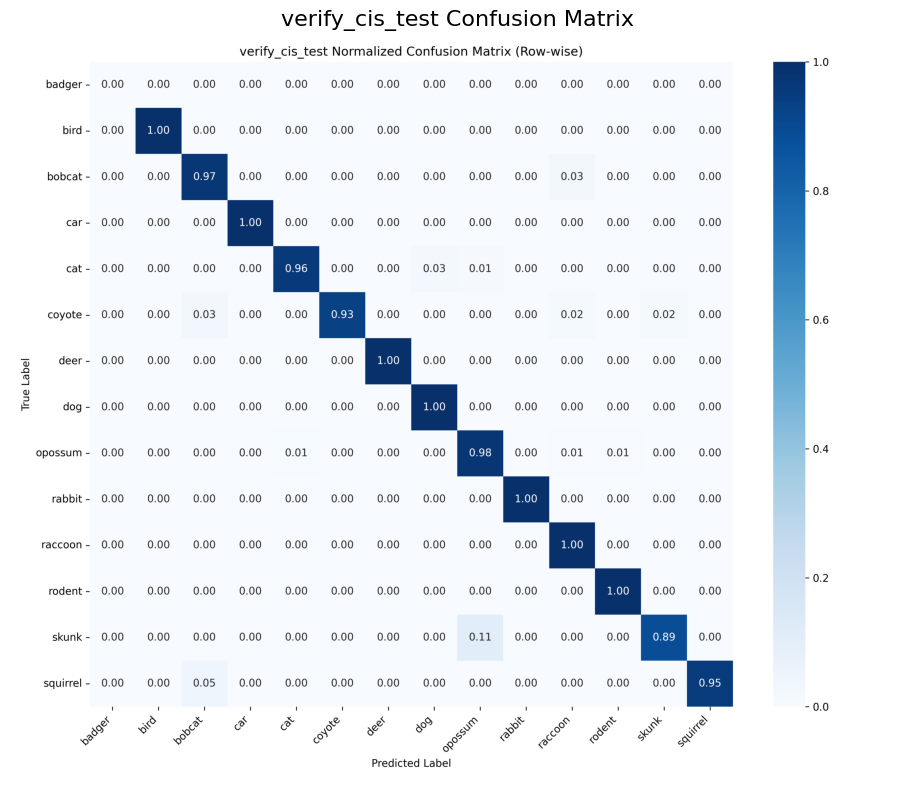

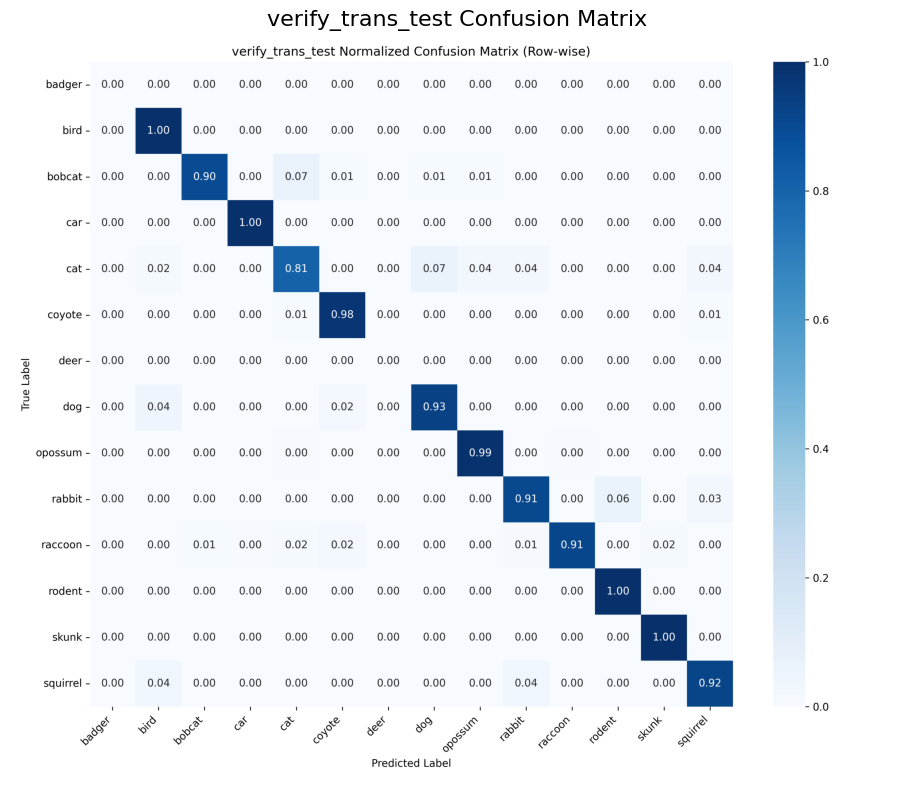

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# File paths
png_paths = {
    "verify_cis_test": "reports/eval_reports/verify_cis_test_confusion_matrix.png",
    "verify_trans_test": "reports/eval_reports/verify_trans_test_confusion_matrix.png"
}

# Plot
for split, path in png_paths.items():
    img = mpimg.imread(path)
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{split} Confusion Matrix", fontsize=16)
    plt.tight_layout()
    plt.show()


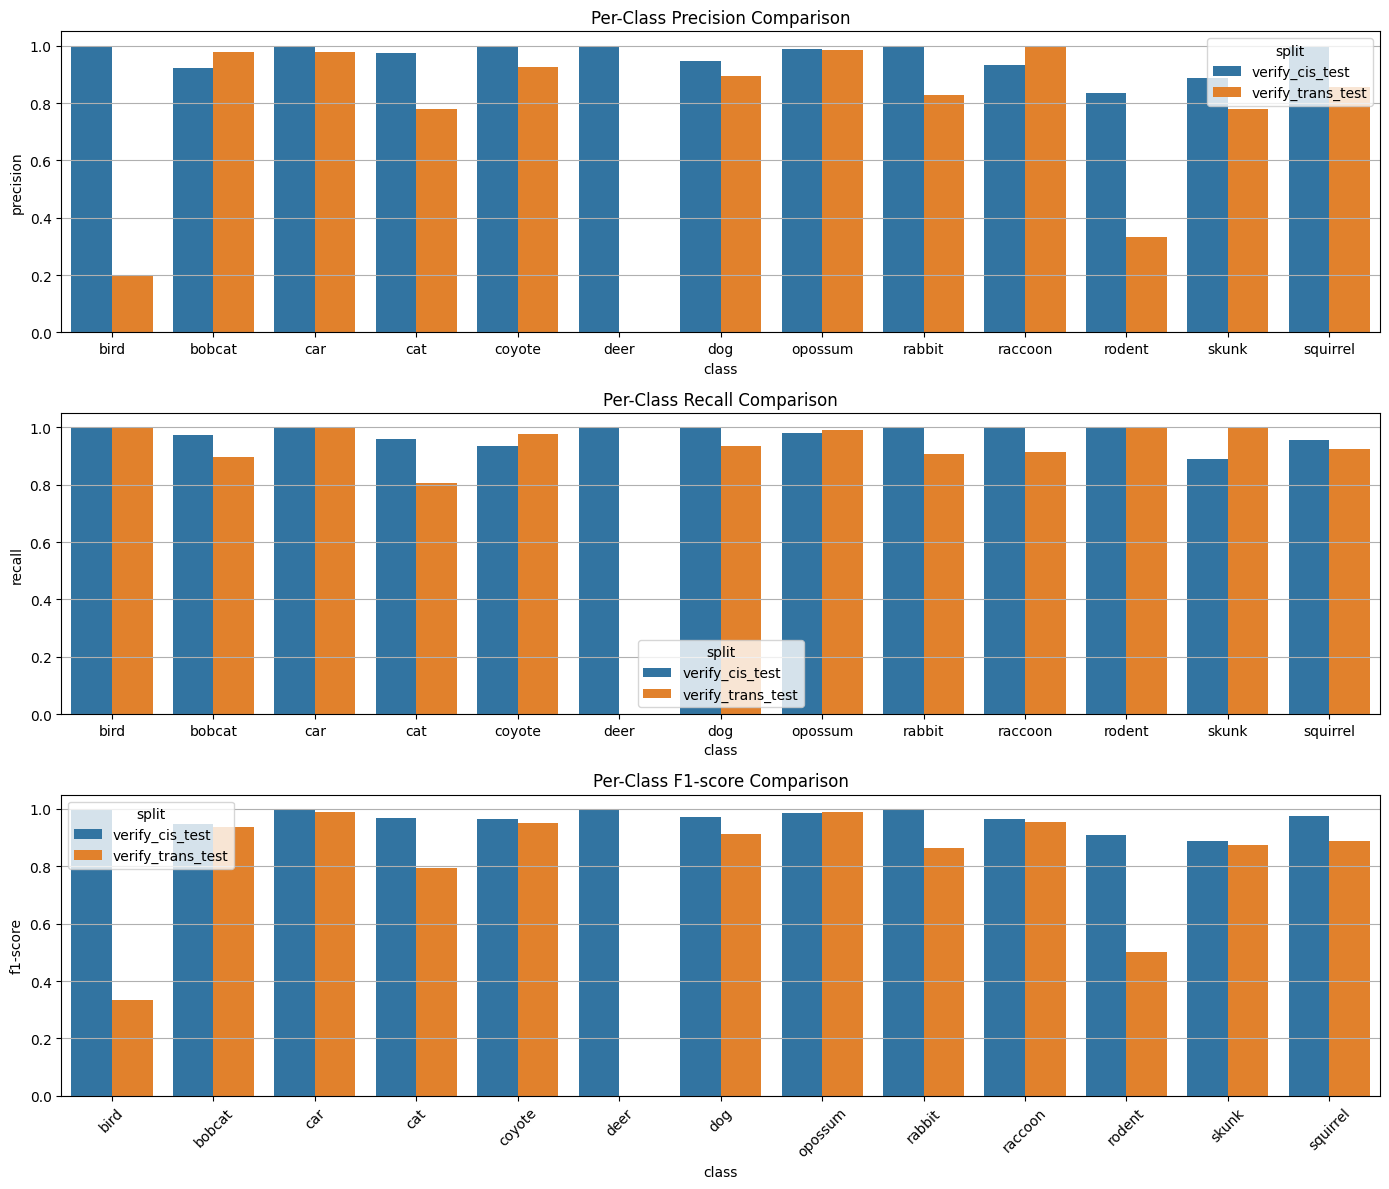

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load classification report CSVs ---
cis = pd.read_csv(OUTPUT_CSV_DIR /"verify_cis_test_classification_report.csv", index_col=0)
trans = pd.read_csv(OUTPUT_CSV_DIR /"verify_trans_test_classification_report.csv", index_col=0)

# Drop summary rows
cis = cis.drop(index=["accuracy", "macro avg", "weighted avg"], errors="ignore")
trans = trans.drop(index=["accuracy", "macro avg", "weighted avg"], errors="ignore")

# Add split tag
cis["split"] = "verify_cis_test"
trans["split"] = "verify_trans_test"
cis["class"] = cis.index
trans["class"] = trans.index

# Combine both
metrics = pd.concat([cis, trans], ignore_index=True)

# --- Plot precision / recall / f1-score ---
fig, axs = plt.subplots(3, 1, figsize=(14, 12))
for ax, metric in zip(axs, ["precision", "recall", "f1-score"]):
    sns.barplot(data=metrics, x="class", y=metric, hue="split", ax=ax)
    ax.set_title(f"Per-Class {metric.capitalize()} Comparison")
    ax.set_ylim(0, 1.05)
    ax.grid(axis="y")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


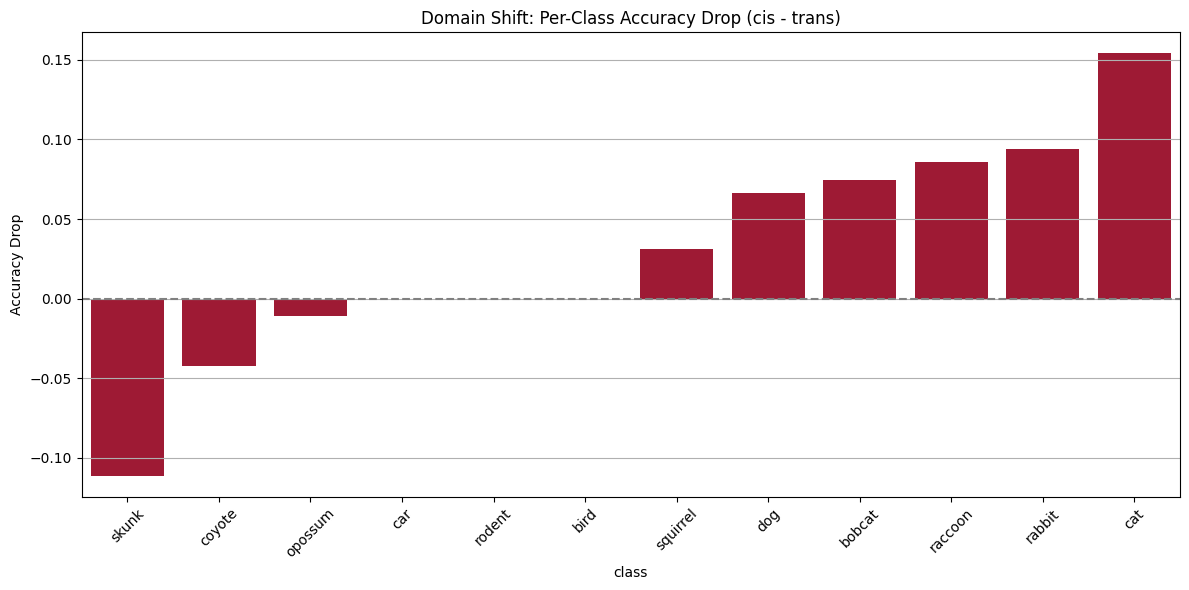

In [14]:

# Load both metric files
cis_df = pd.read_csv("reports/eval_reports/verify_cis_test_comprehensive_metrics.csv")
trans_df = pd.read_csv("reports/eval_reports/verify_trans_test_comprehensive_metrics.csv")

cis_row = cis_df.iloc[0]
trans_row = trans_df.iloc[0]

# Get common accuracy columns
cis_cols = set(cis_df.columns)
trans_cols = set(trans_df.columns)
common_accuracy_cols = [col for col in cis_cols & trans_cols if col.endswith("_accuracy") and col not in ["overall_accuracy", "weighted_f1"]]

# Compute drops only on shared accuracy metrics
drops = []
for col in common_accuracy_cols:
    drops.append({
        "class": col.replace("_accuracy", ""),
        "accuracy_drop": cis_row[col] - trans_row[col]
    })

drop_df = pd.DataFrame(drops).sort_values("accuracy_drop")

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=drop_df, x="class", y="accuracy_drop", hue=x, legend=False, palette="coolwarm_r")
plt.axhline(0, color="gray", linestyle="--")
plt.title("Domain Shift: Per-Class Accuracy Drop (cis - trans)")
plt.ylabel("Accuracy Drop")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.show()


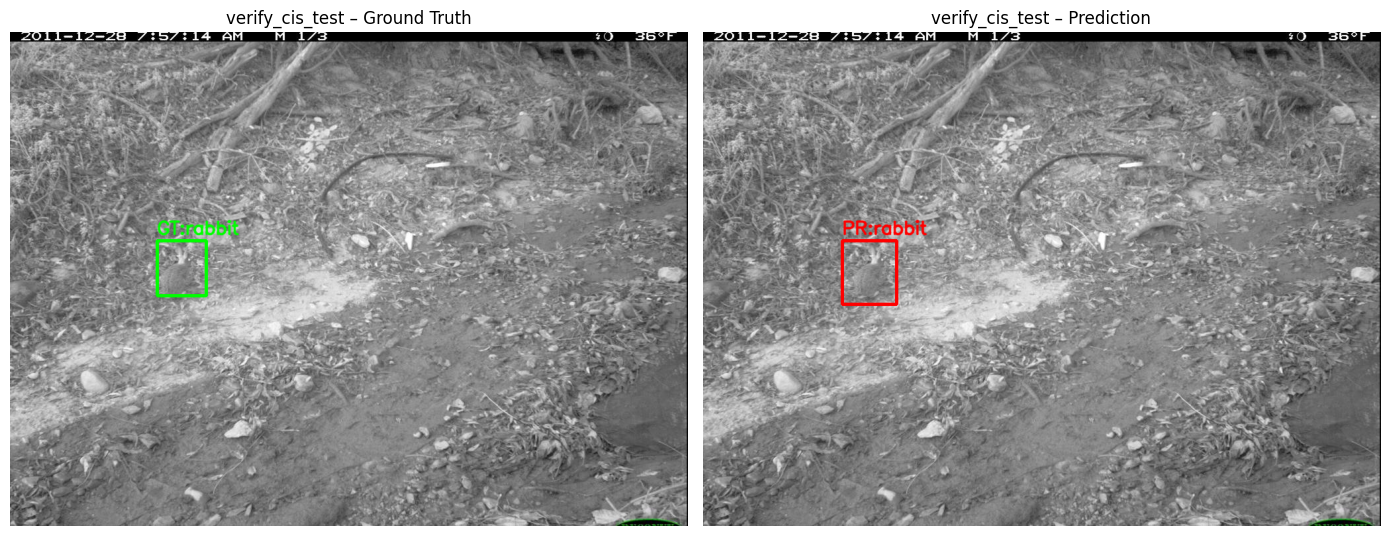

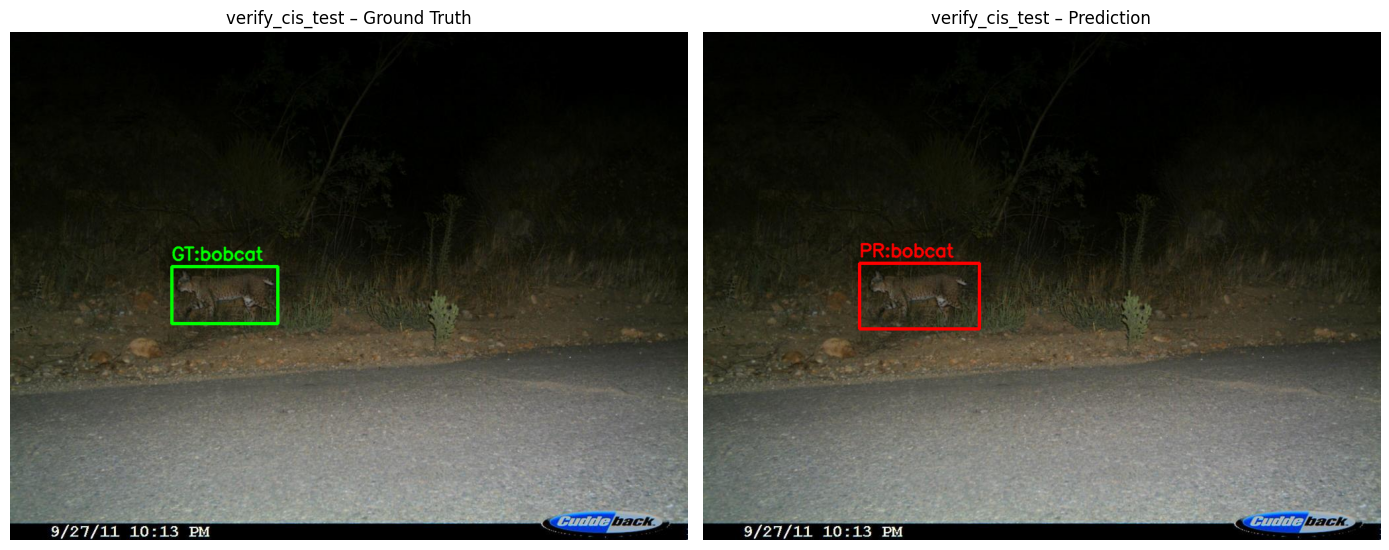

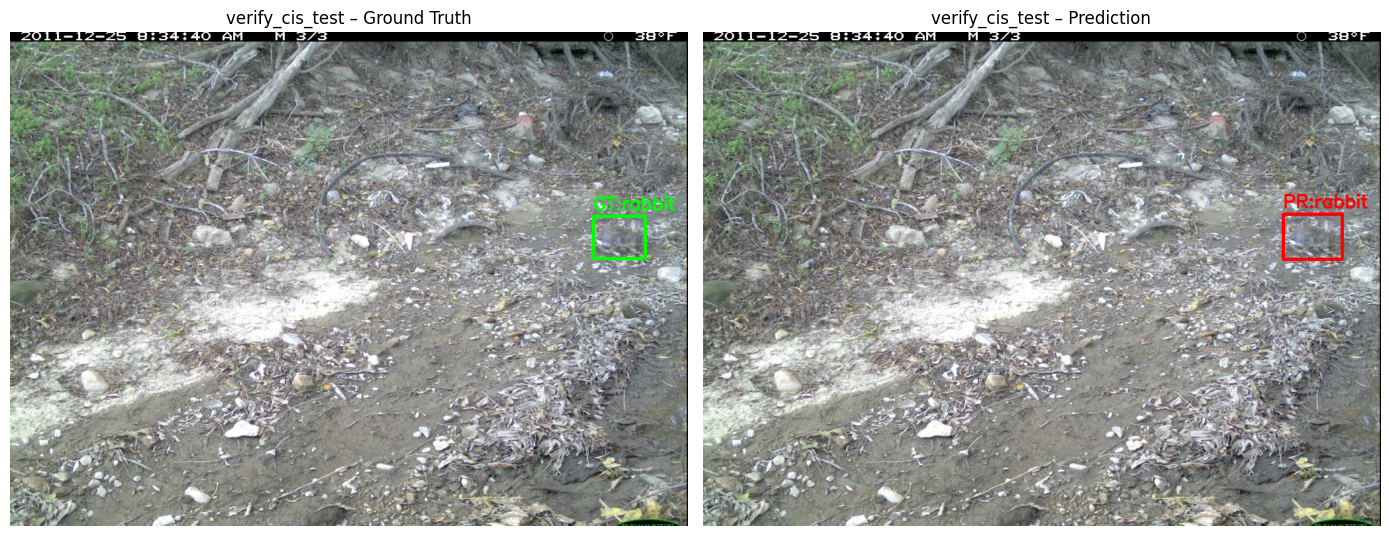

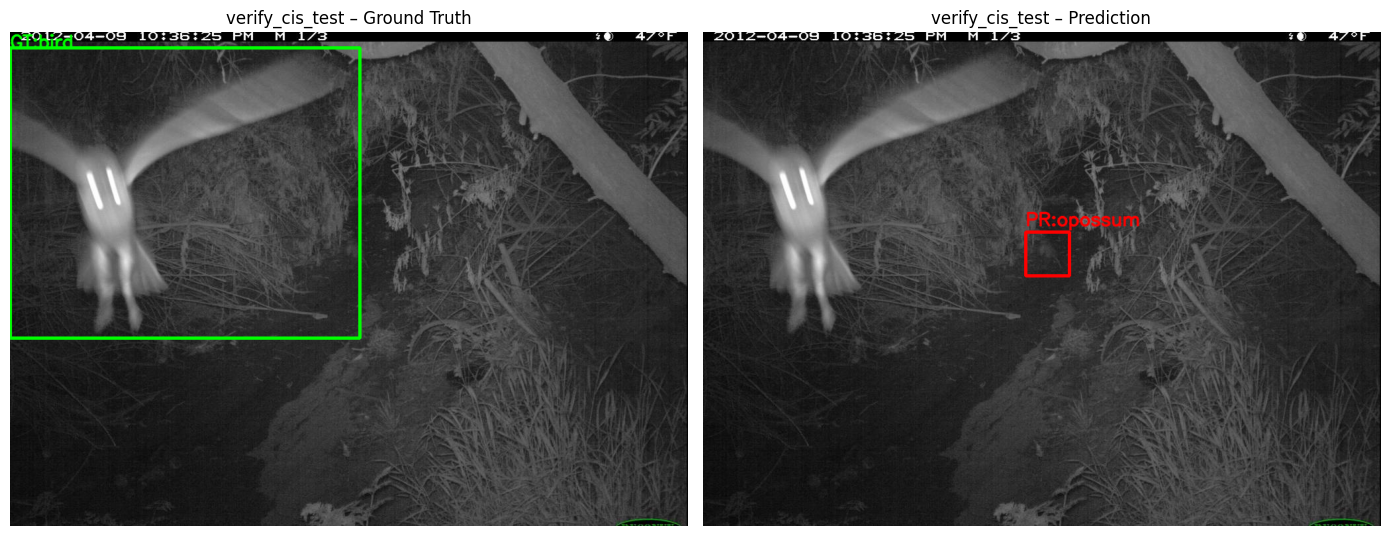

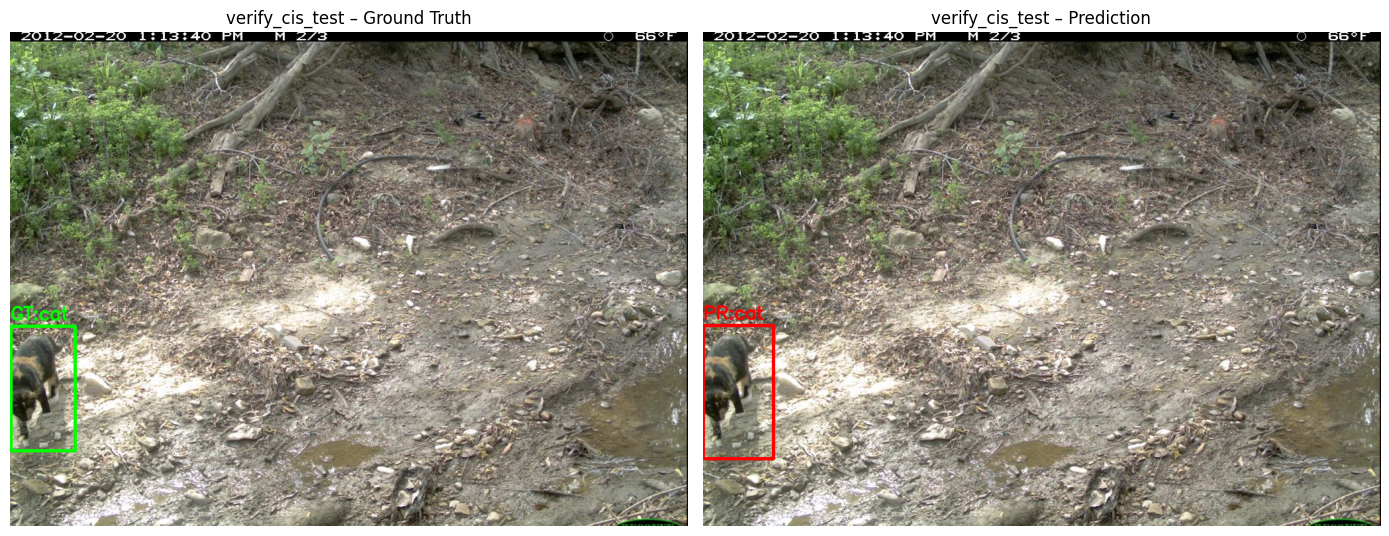

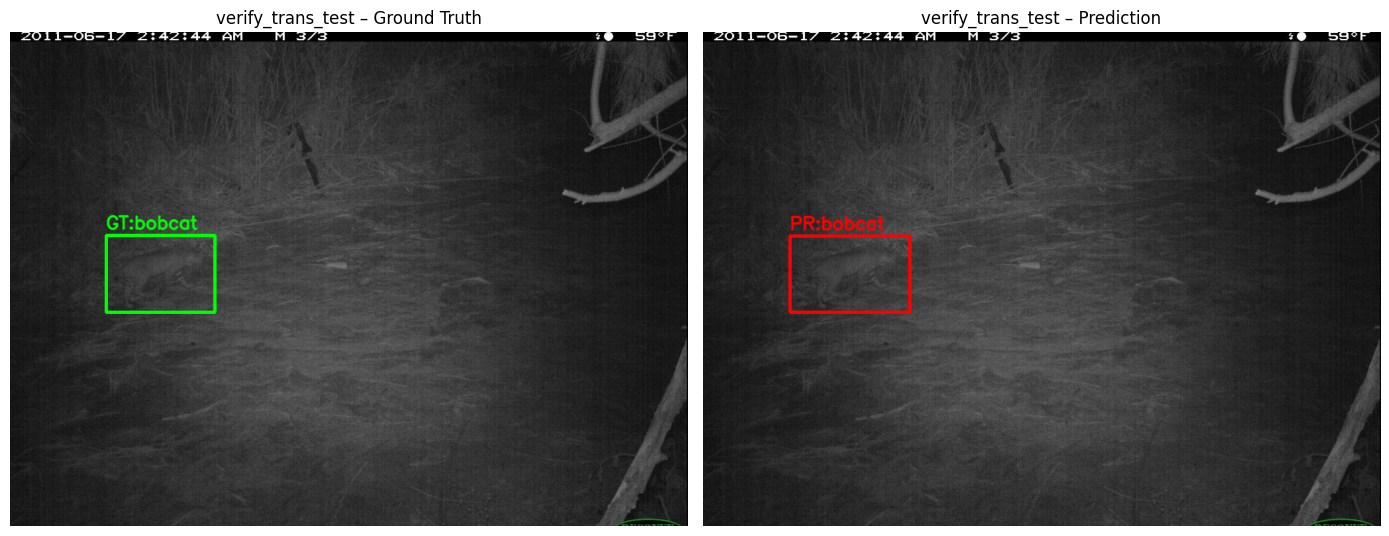

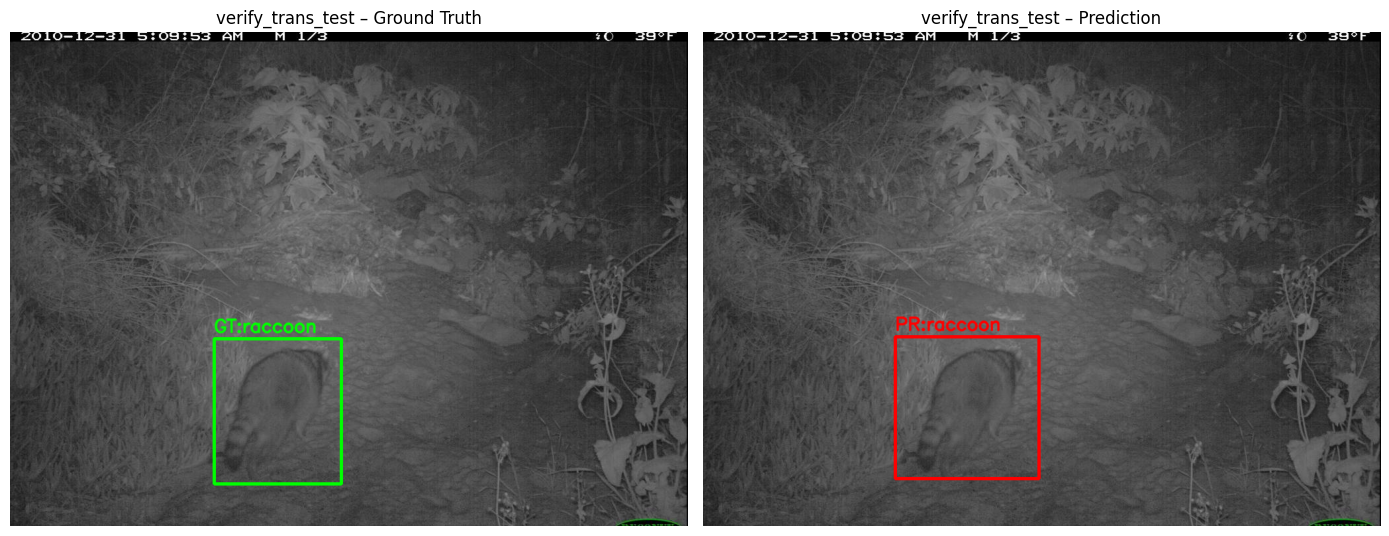

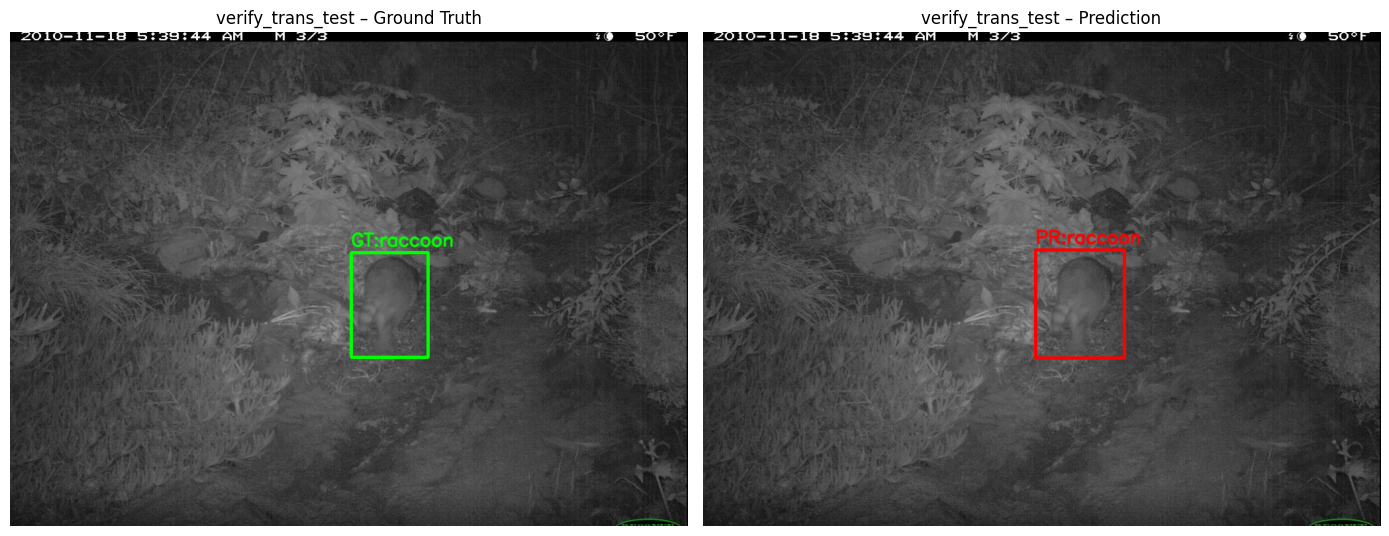

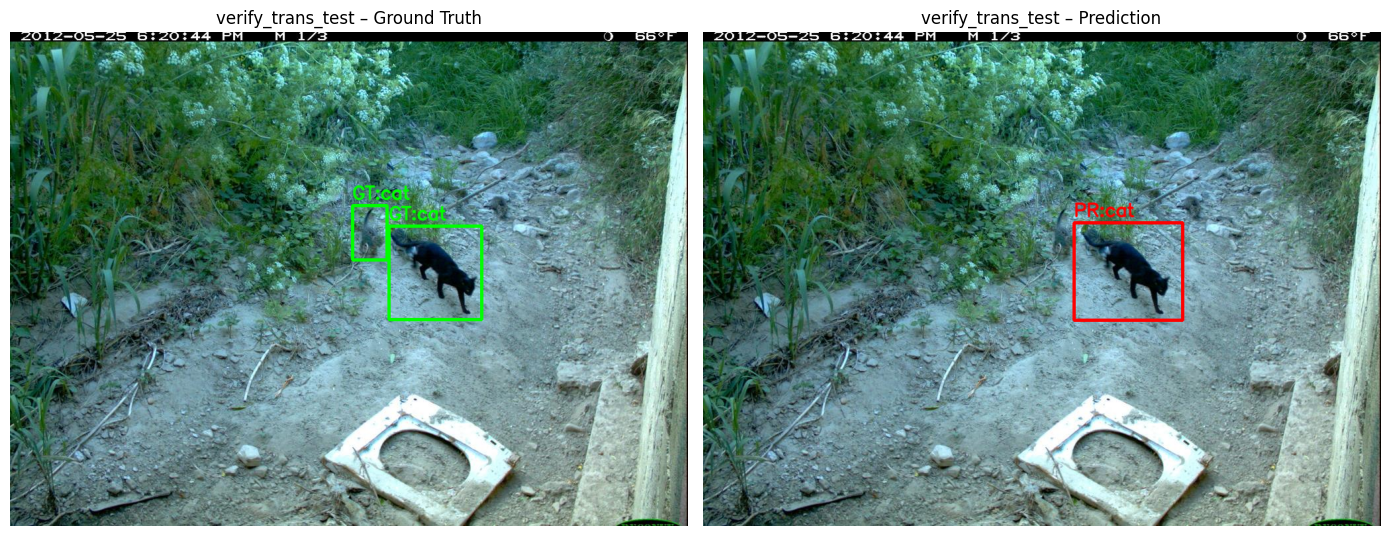

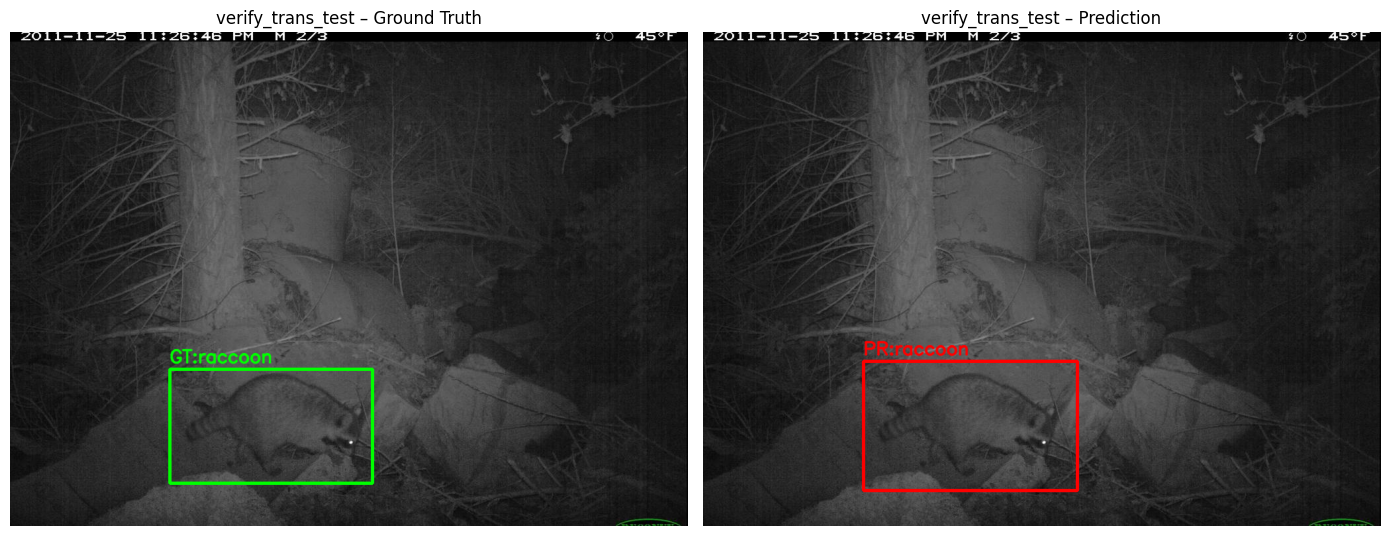

In [15]:
import json
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import random

# --- CONFIG ---
splits = ["verify_cis_test", "verify_trans_test"]
img_dir = Path("data/verification")

pred_jsons = {
    split: Path("reports") / f"{split}_final_predictions.json" for split in splits
}
category_id_to_name = {
    6: "bobcat", 1: "opossum", 9: "coyote", 3: "raccoon", 11: "bird", 8: "dog",
    16: "cat", 5: "squirrel", 10: "rabbit", 7: "skunk", 99: "rodent", 21: "badger",
    34: "deer", 33: "car"
}

def draw_boxes(image, boxes, color, prefix):
    for box in boxes:
        x1, y1, x2, y2 = map(int, box["bbox"])
        label = category_id_to_name.get(box["category_id"], str(box["category_id"]))
        text = f"{prefix}:{label}"


        cv2.rectangle(image, (x1, y1), (x2, y2), color, 3)

         # Font settings
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.9
        font_thickness = 2
        (text_width, text_height), _ = cv2.getTextSize(text, font, font_scale, font_thickness)

        # For cars: place label at top-left
        if label == "car":
            tx, ty = x1 + 5, y1 + text_height + 5
        else:
            tx, ty = x1, max(y1 - 10, text_height + 5)


        cv2.putText(image,
                    text,
                    (tx, ty),
                    font,
                    font_scale,
                    color,
                    font_thickness,
                    lineType=cv2.LINE_AA)
    return image

for split in splits:
    # Load GT
    with open(JSON_PATHS[split]) as f:
        gt_data = json.load(f)
    id2file = {img["id"]: img["file_name"] for img in gt_data["images"]}
    gt_map = {}
    for ann in gt_data["annotations"]:
        fname = id2file[ann["image_id"]]
        x, y, w, h = ann["bbox"]
        gt_map.setdefault(fname, []).append({
            "bbox": [x, y, x + w, y + h],
            "category_id": ann["category_id"]
        })

    # Load predictions
    with open(pred_jsons[split]) as f:
        preds = json.load(f)
    pred_map = {}
    for p in preds:
        pred_map.setdefault(p["filename"], []).append({
            "bbox": p["bbox"],
            "category_id": p["category_id"]
        })

    # Pick 5 images with both GT and predictions
    filenames = list(set(gt_map) & set(pred_map))
    
    sampled = random.sample(filenames, k=min(5, len(filenames)))
    for fname in sampled:
        img = cv2.imread(str(img_dir / fname))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        gt_img = draw_boxes(img.copy(), gt_map[fname], (0, 255, 0), "GT")
        pr_img = draw_boxes(img.copy(), pred_map[fname], (255, 0, 0), "PR")

        # Side-by-side
        fig, axs = plt.subplots(1, 2, figsize=(14, 7))
        axs[0].imshow(gt_img)
        axs[0].set_title(f"{split} – Ground Truth")
        axs[0].axis("off")

        axs[1].imshow(pr_img)
        axs[1].set_title(f"{split} – Prediction")
        axs[1].axis("off")

        plt.tight_layout()
        plt.show()
